
1.   Reed-solomon ec for test cases 7, 10, 13, 15
4.   Decode v3 for test case 15, 16






In [589]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import reedsolo as rs

In [590]:
def calculate_shift_left(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = 0
    for row in image:
        while  index < len(row) and row[index] != 0:
            current_counter += 1
            index += 1
        index = 0
        if current_counter == len(row):
            continue

        else:
            counts_until_first_black_pixel.append(current_counter)

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_up(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = 0
    for col in image.T:
        while  index < len(col) and col[index] != 0:
            current_counter += 1
            index += 1
        index = 0
        if current_counter == len(col):
            continue

        else:
            counts_until_first_black_pixel.append(current_counter)

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_right(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = image.shape[1] - 1
    for row in image:
        while  index >= 0 and row[index] != 0:
            current_counter += 1
            index -= 1
        index = image.shape[1] - 1
        if current_counter == len(row):
            continue

        else:
            counts_until_first_black_pixel.append(current_counter)

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_down(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = image.shape[0] - 1
    for col in image.T:
        while  index >= 0 and col[index] != 0:
            current_counter += 1
            index -= 1
        index = image.shape[1] - 1
        if current_counter == len(col):
            continue

        else:
            counts_until_first_black_pixel.append(current_counter)

        current_counter = 0
    return counts_until_first_black_pixel


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    if pad_width[1] != 0:
        vector[-pad_width[1]:] = pad_value

def even_quiet_zone(image):
    left = np.min(calculate_shift_left(image))
    right = np.min(calculate_shift_right(image))
    up = np.min(calculate_shift_up(image))
    down = np.min(calculate_shift_down(image))

    maximum_width = max([left, right, up, down])

    top_pad = maximum_width - up
    bottom_pad = maximum_width - down
    left_pad = maximum_width - left
    right_pad = maximum_width - right

    return np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad)), pad_with, padder=255)

In [591]:
def check_pattern(cells):
    """
    Check if the mean value of each cell in cells is within a tolerance of the corresponding value in the pattern.
    """
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    tolerance = 100
    results = [abs(int(np.mean(cell)) - pat) <= tolerance for cell, pat in zip(cells, pattern)]
    return all(results)

def rotate_image(image, degrees):
    return np.rot90(image, degrees // 90)

def check_valid_format(og, qr_cells, grid_cells_num, grid_cell_size):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    ecl = [int(not(c)) for c in qr_cells_numeric[19:21, 8]]
    mask = [int(not(c)) for c in qr_cells_numeric[18:15:-1, 8]]
    fec = np.concatenate(([qr_cells_numeric[15, 8]], [qr_cells_numeric[14, 8]], qr_cells_numeric[8, 13:21][::-1]))  # Reverse to get from col 20 to col 13
    fec = [int(not(c)) for c in fec]

    ecl_check = [int(not(c)) for c in qr_cells_numeric[8, :2]]
    mask_check = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    fec_check = np.concatenate(([qr_cells_numeric[8, 5]], [qr_cells_numeric[8, 7]], qr_cells_numeric[7:9,8][::-1], qr_cells_numeric[0:6,8][::-1]))
    fec_check = [int(not(c)) for c in fec_check]

    print(ecl + mask + fec == ecl_check + mask_check + fec_check)
    if not (ecl + mask + fec == ecl_check + mask_check + fec_check):
        revert = rotate_image(qr_cells, 270)
        return cv2.flip(og, 1).reshape((grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size)).swapaxes(1, 2)
    else:
        return qr_cells

def correct_orientation(og, qr_cells, grid_cells_num, grid_cell_size):
    """
    Correct the orientation of the QR code by checking the patterns in the corners and rotating if necessary.
    """
    # Check patterns in the corners
    bottom_right = qr_cells[grid_cells_num - 4, -7:], qr_cells[-7:, grid_cells_num-4]
    top_right = qr_cells[3, -7:], qr_cells[:7, grid_cells_num-4]
    bottom_left = qr_cells[grid_cells_num-4, :7], qr_cells[-7:, 3]


    # If the bottom right corner does not match the pattern, the QR code is in the correct orientation
    if not any(map(check_pattern, bottom_right)):
        return qr_cells

    # If all corners match the pattern, rotate 180 degrees
    if all(map(check_pattern, top_right + bottom_left)):
        return rotate_image(qr_cells, 180)

    # If the top right and bottom right corners match the pattern, rotate 270 degrees
    if all(map(check_pattern, top_right + bottom_right)):
        rotated = rotate_image(qr_cells, 90)
        return check_valid_format(og, rotated, grid_cells_num, grid_cell_size)


    # If the bottom left and bottom right corners match the pattern, rotate 90 degrees
    if all(map(check_pattern, bottom_left + bottom_right)):
        return rotate_image(qr_cells, 270)

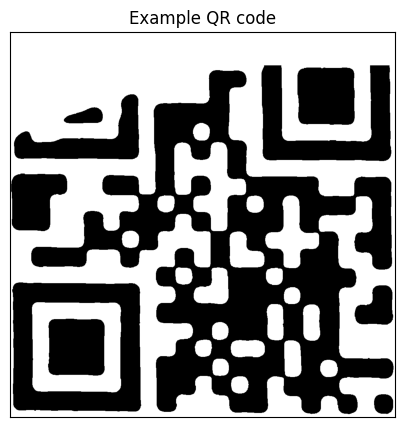

In [592]:
img = cv2.imread("./preprocessed_images/output_10.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code')
plt.imshow(img, cmap='gray');

In [593]:
grid_cells_num = 21
grid_cell_size = 50

# gotta find a new way to get the qr without the quiet zone
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break


for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break


# Align the start and end rows and columns
diff_row = min(start_row, img.shape[0] - end_row)
diff_col = min(start_col, img.shape[1] - end_col)

print(start_row, end_row, start_col, end_col, diff_row, diff_col)
# 44 968 44 968

91 1042 3 1046 8 3


In [594]:
qr_no_quiet_zone = img[diff_row:img.shape[0] - diff_row, diff_col:img.shape[1] - diff_col]
qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (grid_cells_num * grid_cell_size, grid_cells_num * grid_cell_size), interpolation=cv2.INTER_AREA)

In [595]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 50, 50)


In [596]:
corrected_qr = correct_orientation(qr_no_quiet_zone, qr_cells, grid_cells_num, grid_cell_size)

In [597]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(corrected_qr):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0]
 [1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0]
 [1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0]
 [1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0]
 [0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0]
 [0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0]
 [1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0]
 [1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0]
 [1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0]
 [0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1]
 [0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1]
 [0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]
 [0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0]]


## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [598]:
# We want row #8
# qr_cells_numeric[8]
qr_cells_numeric[19:21, 8]

array([0, 0], dtype=uint8)

In [599]:
# The last two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not(c)) for c in qr_cells_numeric[19:21, 8]]  # We'll read the ecl from the bottom locator instead
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)


[1, 1]


### Mask pattern

In [600]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
# We'll read the mask pattern from the three bits before the ecl in col 8
mask = [int(not(c)) for c in qr_cells_numeric[18:15:-1, 8]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)

100


### Format error correction

In [601]:
# We'll get #15, #14 from col 8 since #13 is always black
# We'll also get row 8 from last col to col 13
fec = []
fec.append(qr_cells_numeric[15, 8])
fec.append(qr_cells_numeric[14, 8])
fec.extend(qr_cells_numeric[8, 13:21][::-1])  # Reverse to get from col 20 to col 13
fec = [int(not(c)) for c in fec]
print(fec)


[1, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [602]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [1, 0, 0] [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [603]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [0, 0, 1] [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]


In [604]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]


    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))


    return result[:4] if direction == UP_ENC else result





### Data encoding

### Data length

In [605]:
data_starting_indices = [
    [grid_cells_num-1, grid_cells_num-1, UP_ENC],
    [grid_cells_num-3, grid_cells_num-1, UP],
    [grid_cells_num-7,  grid_cells_num-1,  UP],
    [grid_cells_num-11, grid_cells_num-1,  CCW],
    [grid_cells_num-10, grid_cells_num-3,  DOWN],
    [grid_cells_num-6,  grid_cells_num-3,  DOWN],
    [grid_cells_num-2,  grid_cells_num-3,  CW],
    [grid_cells_num-3,  grid_cells_num-5,  UP],
    [grid_cells_num-7,  grid_cells_num-5,  UP],
    [grid_cells_num-11, grid_cells_num-5,  CCW],
    [grid_cells_num-10, grid_cells_num-7,  DOWN],
    [grid_cells_num-6,  grid_cells_num-7,  DOWN],
    [grid_cells_num-2,  grid_cells_num-7,  CW],
    [grid_cells_num-3,  grid_cells_num-9,  UP],
    [grid_cells_num-7,  grid_cells_num-9,  UP],
    [grid_cells_num-11, grid_cells_num-9,  UP],
    [grid_cells_num-16, grid_cells_num-9,  UP],
    [grid_cells_num-20, grid_cells_num-9,  CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],  # End of message (Terminator)
    [grid_cells_num-12, grid_cells_num-11, DOWN],  # E1
    [grid_cells_num-8,  grid_cells_num-11, DOWN],  # E2
    [grid_cells_num-4,  grid_cells_num-11, DOWN],  # E3
    [grid_cells_num-9,  grid_cells_num-13, UP],    # E4
    [grid_cells_num-12, grid_cells_num-16, DOWN],  # E5
    [grid_cells_num-9,  grid_cells_num-18, UP],    # E6
    [grid_cells_num-12, grid_cells_num-20, DOWN],  # E7
]

Alphanumeric Mode Decoding

In [606]:
ALPHANUMERIC_TABLE = {

    0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
    5: '5', 6: '6', 7: '7', 8: '8', 9: '9',

    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
    15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
    25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
    35: 'Z',

    36: ' ', 37: '$', 38: '%', 39: '*',
    40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
}

def bin_to_alphanum(bits):

    num = int(bits, 2)

    # This part is similar to saying that 78 = 7 * 10 + 8
    # Originally if we're encoding alpahnumeric characters for example TH (T:29, H:17)
    # We would get the binary string by converting 29 * 45 + 17 to binary

    first_num = num // 45
    first_char = ALPHANUMERIC_TABLE[first_num]

    second_num = num % 45
    second_char = ALPHANUMERIC_TABLE[second_num]

    return first_char + second_char

def decode_alphanumeric_v1():
    ans = ''
    data_string = ''
    for a, b, d in data_starting_indices:
        bits = apply_mask(a, b, d)
        # Convert list of bits to string and concatenate to data_string
        data_string += ''.join([str(bit) for bit in bits])

    print(f"data_string: {data_string}")

    # Exclude the first 4 bits of the encoding type
    data_string = data_string[4:]
    print(f"data_string_no_enc: {data_string}")
    # The length should be read in the next 9 bits
    length = int(data_string[:9], 2)
    #print(f"length: {length}")

    data_string = data_string[9:]
    print(f"data_string_no_len: {data_string}")

    # Process the data 11 bits by 11 bits
    while length > 1:
        chars = bin_to_alphanum(data_string[:11])
        ans += chars
        print(f'{data_string[:11]} = {chars}')
        data_string = data_string[11:]
        length -= 2

    # If the number of characters in the to be decoded string is odd, the last character is represented in 6 bits
    if length == 1:
        last_char = ALPHANUMERIC_TABLE[int(data_string[:6], 2)]
        ans += last_char
        print(f'{data_string[:6]} = {last_char}')

    print(f'\nDecoded string: {ans}')


### Data extraction

In [607]:
def decode_byte_mode_v1():
  lookup = {
      '11': 7,
      '10': 10,
      '01': 13,
      '00': 17
  }
  key = ''.join(map(str, ecl))
  message_bits = []
  enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
  length = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
  print(length, ecl)
  message_bits.extend(enc)
  message_bits.extend(length)
  extracted_data_no_error_correction = ''
  for i, (a, b, d) in enumerate(data_starting_indices):  # For each starting index and direction
      if i < 2:  # Skip the first two indices
          continue
      bits = apply_mask(a, b, d)  # Extract the bits per the indexed QR code symbol
      bit_string = ''.join([str(bit) for bit in bits])  # Convert to string of bits
      alpha_char = chr(int(bit_string, 2))  # Convert binary to int, then to a char
      if bit_string[:4] == "0000":  # If the first 4 bits are 0s, this is the END
          print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
          message_bits.extend(bits[:4])  # Append only the four bits
      else:  # If not the END symbol, append full set of bits
          message_bits.extend(bits)
          extracted_data_no_error_correction += alpha_char
      print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

  print(f'\ni.e., the data and ECCs in the QR code as-is are "{extracted_data_no_error_correction}"')

  # use the reedsolo library to decode the message and correct any errors
  # For every 8 bits in the extracted message, convert to a byte
  extracted_data_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
  reed_solomon = rs.RSCodec(lookup[key]) # Create a Reed-Solomon codec object with 7 error correction bytes
  print(f'\nDecoding the message using Reed-Solomon error correction...')
  try:
        decoded_data_bytes = reed_solomon.decode(extracted_data_bytes)  # Decode the message
    #   decoded_data = ''.join([chr(byte) for byte in decoded_data_bytes])  # Convert bytes to characters
        reed_solomon.maxerrata(verbose=True)
        print(f'The decoded message is: "{decoded_data_bytes[0].decode(encoding="iso-8859-1")}"')
        data_bits = bin(int.from_bytes(decoded_data_bytes[0], byteorder='big'))[13:-4]
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
  except rs.ReedSolomonError as e:
      print(f'Error decoding the message: {str(e)}')
      # Extract data without error correction

In [608]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
if enc == [0, 0, 1, 0]:
  decode_alphanumeric_v1()
else:
  decode_byte_mode_v1()

[0, 0, 0, 0, 1, 1, 1, 1] [0, 1]
01000111 (=071) = G
01101111 (=111) = o
01101110 (=110) = n
01100101 (=101) = e
01010111 (=087) = W
01101001 (=105) = i
01110100 (=116) = t
01101000 (=104) = h
01010100 (=084) = T
01101000 (=104) = h
01100101 (=101) = e
01010111 (=087) = W
01101001 (=105) = i
01101110 (=110) = n
01100100 (=100) = d
00111100 (=060) = <
11000001 (=193) = Á
00010101 (=021) = 
01010010 (=082) = R
10101101 (=173) = ­
01000111 (=071) = G
11010001 (=209) = Ñ
00101111 (=047) = /
0000...         = NULL TERMINATOR (END Symbol, SKIP!)
00001100 (=012) = 
11000001 (=193) = Á

i.e., the data and ECCs in the QR code as-is are "GoneWithTheWind<ÁR­GÑ/Á"

Decoding the message using Reed-Solomon error correction...
Error decoding the message: Too many errors to correct
